# Build functions to load comment_id

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
from random import sample 
import sqlite3
import random 
import math
import csv

import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from mlxtend.plotting import ecdf

In [2]:
## setup
DBNAME = "2019-12-09_with_sample.db"
conn = sqlite3.connect(DBNAME)
c = conn.cursor()
engine = create_engine('sqlite:///'+ DBNAME, echo=False)

comments_df = pd.read_sql("SELECT * FROM Comment", conn)
submission_df = pd.read_sql("SELECT * FROM Submission", conn)
subreddit_df = pd.read_sql("SELECT * FROM Subreddit", conn)
user_dup_df = pd.read_sql("SELECT * FROM User_duplicate", conn)
combined_df = pd.read_sql("SELECT comment.Id AS comment_id, comment.parent_comment_id, comment.commentor_id, comment.commentor_name, comment.commentee_id, comment.commentee_name, comment.score, submission.id AS submission_id, \
                       subreddit.id AS subreddit_id, subreddit.topic, subreddit.attitude \
                        FROM comment JOIN submission ON comment.submission_id = submission.id \
                        JOIN subreddit ON submission.subreddit_id = subreddit.id", conn).dropna(subset=['commentor_id', 'commentee_id'])
combined_df = combined_df.merge(user_dup_df, on=['topic','commentor_id'])

In [145]:
count_all_user = combined_df[['topic','commentor_id']].groupby('topic').nunique().drop(columns=['topic']).reset_index()
count_all_user.columns = ['topic', 'all_user']
count_all_meds = meds_df[['topic','commentor_id']].groupby('topic').nunique().drop(columns=['topic']).reset_index()
count_all_meds.columns = ['topic', 'mediator']
merge_temp = count_all_user.merge(count_all_meds, on='topic')
merge_temp['percentage'] = round(merge_temp['mediator']/merge_temp['all_user'],3)
merge_temp

,topic,all_user,mediator,percentage
0,abortion,1309,44,0.034
1,business,2255,48,0.021
2,conspiracy_science,15521,57,0.004
3,football,1060,1,0.001
4,gun,4788,186,0.039
5,trump,2710,14,0.005


[Text(0, 0, 'gun'),
 Text(0, 0, 'abortion'),
 Text(0, 0, 'trump'),
 Text(0, 0, 'football'),
 Text(0, 0, 'conspiracy_science'),
 Text(0, 0, 'business'),
 Text(0, 0, 'climate')]

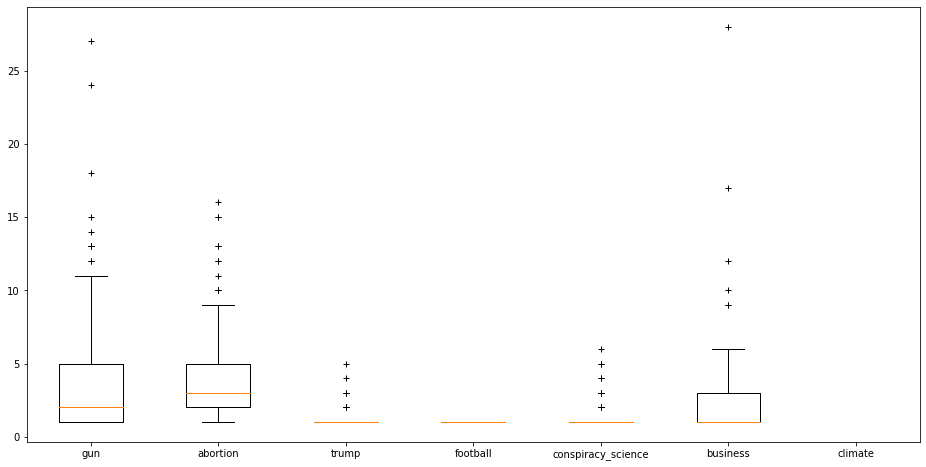

In [121]:
topic_df = meds_df[['submission_id','topic','commentor_id']].groupby(['topic','submission_id']).nunique().drop(columns=['topic','submission_id']).reset_index()
topic_ls = combined_df.topic.unique().tolist()
fig, ax = plt.subplots(figsize=(16,8))
topic_meds_ls = []
for topic in topic_ls:
    meds_num_ls = topic_df[topic_df['topic']==topic]['commentor_id'].tolist()
    topic_meds_ls.append(meds_num_ls)

#pos = np.arange(len(meds_num_ls)
bp = ax.boxplot(topic_meds_ls,
               notch=0, sym='+', vert=1, whis=1.5,)

ax.set_xticklabels(topic_ls)    

In [104]:
## counting mediator's comments

meds_df = combined_df[combined_df['label']=="mediator"]
count_medsc_df = meds_df[['submission_id', 'label']].groupby('submission_id').count().reset_index()
count_medsc_df.columns = ['submission_id', 'num_mediator']
count_meds_df

#fig, ax = plt.subplots(figsize=(12,6))
#n, bins, patches = plt.hist(count_medsc_df['num_mediator'], 50, facecolor='b', alpha=0.75)
#plt.xlabel("Number of Mediator's Comments", fontsize=15)
#plt.ylabel("Count", fontsize=15)
#plt.title("Distribution of Mediator's Comment Number Across All Sumissions", fontsize=15)
#plt.grid(True)
#plt.show()

meds_df_tree = meds_df[meds_df['parent_comment_id'].values.astype('<U1') == 'f']
count_medsc_df2 = meds_df_tree[['parent_comment_id','label']].groupby('parent_comment_id').count().reset_index()
count_medsc_df2.columns = ['parent_comment_id', 'num_mediator']

#fig, ax = plt.subplots(figsize=(12,6))
#n, bins, patches = plt.hist(count_medsc_df2['num_mediator'], facecolor='b', alpha=0.75)
#plt.xlabel("Number of Mediators's Comments", fontsize=15)
#plt.ylabel("Count of Comment Tree", fontsize=15)
#ax.set_yscale('log')
#plt.title("Distribution of Mediator's Comments in each Comment Tree", fontsize=15)
#plt.grid(True)
#plt.show()

count_medsc_df3 = meds_df[['subreddit_id', 'label', ]].groupby('subreddit_id').count().reset_index()
count_medsc_df3.columns = ['subreddit_id', 'num_mediator']
#count_meds_df

#fig, ax = plt.subplots(figsize=(12,6))
#n, bins, patches = plt.hist(count_medsc_df3['num_mediator'], facecolor='b', alpha=0.75)
#plt.xlabel("Number of Mediators's Comments", fontsize=15)
#plt.ylabel("Count of Subreddit", fontsize=15)
#plt.title("Distribution of Mediator's Comments in each Subreddit", fontsize=15)
#plt.grid(True)
#plt.show()

In [106]:
## counting mediators

meds_df
count_meds_df = meds_df[['submission_id', 'commentor_id']].groupby('submission_id').nunique().drop(columns=['submission_id']).reset_index()
count_meds_df.columns = ['subreddit_id', 'num_mediator']

#fig, ax = plt.subplots(figsize=(12,6))
#n, bins, patches = plt.hist(count_meds_df['num_mediator'], facecolor='b', alpha=0.75)
#plt.xlabel("Number of Mediators", fontsize=15)
#plt.ylabel("Count", fontsize=15)
#plt.title("Distribution of Mediator Number Across All Sumissions", fontsize=15)
#plt.grid(True)
#plt.show()

meds_df_tree = meds_df[meds_df['parent_comment_id'].values.astype('<U1') == 'f']
count_meds_df2 = meds_df_tree[['parent_comment_id', 'commentor_id']].groupby('parent_comment_id').nunique().drop(columns=['parent_comment_id']).reset_index()
count_meds_df2.columns = ['parent_comment_id', 'num_mediator']

#fig, ax = plt.subplots(figsize=(12,6))
#n, bins, patches = plt.hist(count_meds_df2['num_mediator'], facecolor='b', alpha=0.75)
#plt.xlabel("Number of Mediators", fontsize=15)
#plt.ylabel("Count", fontsize=15)
#plt.title("Distribution of Mediator Number Across All Sumissions", fontsize=15)
#plt.grid(True)
#plt.show()

In [102]:
#meds_df.submission_id.nunique()/combined_df.submission_id.nunique()

0.23959537572254336

In [3]:
mediator_comment = combined_df[combined_df['label']=="mediator"]
mediator_comment.comment_id.nunique()

5484

## Function 1

**Goal**: to compare comment threads with and without mediators

**input**: subreddit_id

**output**: a dictionary with parent_comment_id as keys and number of mediators within the tree as values.

Notes:
I added try/except and users_label into Jordan's code (but turns out I don't need the code to build my function), but anyways it's here in case you guys need user's label in the comment tree.

In [5]:
def count_mediators_in_subr(subr_id, minimum_comm=3):
    output_dict = {}
    
    ## find all parent comments within the subrredit
    pcomm_ls = list(set(combined_df[combined_df['subreddit_id']==subr_id]['parent_comment_id'].tolist()))
    
    ## for each parent comment, find all the relies underneath
    for pcomm in pcomm_ls:
#        comm_tree = treemaker(pcomm)  ## I don't need to build the tree, would occupy too much memory
        comment_ls = list(set(combined_df[combined_df['parent_comment_id'] == pcomm]['comment_id'].tolist()))
    
        ## count mediators in the comment tree only when 
        ## there're some replies (>5 in this case) that we would take as convsersations
        if len(comment_ls) >= minimum_comm:
            comm_subdf = combined_df[combined_df['comment_id'].isin(comment_ls)]
            medt_df = comm_subdf[comm_subdf['label']=='mediator']
            num_mediator = len(medt_df)
            output_dict[pcomm] = num_mediator
#        output_df = pd.DataFrame.from_dict(output_dict, orient='index').reset_index()     
    return output_dict


"""
def get_parent_sample_list(count_dict):
    ## given the count dict producted by count_mediators_in_subr()
    ## generate two lists of subreddits (with/without mediators)
    with_mediator = []
    without_mediator = []

    for k,v in count_dict.items():
        if v == 0:
            without_mediator.append(k)
        else:
            with_mediator.append(k)
    
    return (with_mediator, without_mediator)
"""  
#count_mediators_in_subr("2trti")
## this could take a while

'\ndef get_parent_sample_list(count_dict):\n    ## given the count dict producted by count_mediators_in_subr()\n    ## generate two lists of subreddits (with/without mediators)\n    with_mediator = []\n    without_mediator = []\n\n    for k,v in count_dict.items():\n        if v == 0:\n            without_mediator.append(k)\n        else:\n            with_mediator.append(k)\n    \n    return (with_mediator, without_mediator)\n'

## Function 2 

**Goal**: to compare mediators' behaviors in and out of their home communities

**input**: user_id (the user has to be a mediator, otherwise he/she might not have a dominant value

**output**: a dictionary that contains two lists of parent comment_id, one for those parent comments that mediators have participated in their home community (dominant value = subreddit value), and one for those abroad.


In [6]:
mediators = combined_df[combined_df['label']=="mediator"].commentor_id.unique().tolist()
sample_mediators = sample(mediators,200) 

def get_home_abroad_comm_mediator(user_id):
    home_df = combined_df[(combined_df['commentor_id']==user_id) & (combined_df['dominant_att']==combined_df['attitude'])]
    abroad_df = combined_df[(combined_df['commentor_id']==user_id) & (combined_df['dominant_att']!=combined_df['attitude'])]
    home_pcomment_ls = home_df['parent_comment_id'].tolist()
    abroad_pcomment_ls = abroad_df['parent_comment_id'].tolist()
    home_abroad_dict = {"home": home_pcomment_ls, "abroad": abroad_pcomment_ls}
#    output_df = pd.DataFrame.from_dict(home_abroad_dict, orient='columns').reset_index()
    return home_abroad_dict

def get_sample_home_abroad_dict():
    output_dict = {}
    for med_id in sample_mediators:
        output_dict[med_id] = get_home_abroad_comm_mediator(med_id)
    return output_dict

get_sample_home_abroad_dict()

{'5ih32': {'home': ['f74m9tn', 'f75qbr2', 'f755xns', 'f6ozhcf'],
  'abroad': ['f76wu94',
   'f76wu94',
   'f775x5j',
   'f775x5j',
   'f6wc0xj',
   'f6wc0xj',
   'f6wf9rh',
   'f6wf9rh',
   'f6winy2',
   'f6winy2',
   'f6wktpt',
   'f6wktpt',
   'f6wq7m1',
   'f6wq7m1',
   'f6wqwtz',
   'f6wqwtz',
   'dsri9p',
   'dsri9p',
   'f6pud5f',
   'f6pud5f',
   'f72a601',
   'f72a601',
   'f74m9tn',
   'f75qbr2',
   'f755xns',
   'f6ozhcf']},
 '16yi7i': {'home': ['f6w8y24', 'f6ohiqs', 'f6drfrs'],
  'abroad': ['f6wgo4f', 'f6x5u8m']},
 '776sb': {'home': ['f6p5t5j'], 'abroad': ['f71zow5']},
 '14nzho': {'home': ['f6ra4z5', 'f6oxdt2', 'f6phyl7', 'f6brm0c', 'f6h3cu3'],
  'abroad': ['du4xrm',
   'f73jjmk',
   'f6qjj03',
   'f6r3qfb',
   'drypxl',
   'f6lms96',
   'f6lp4hd',
   'f6lydhp',
   'dw3lem',
   'dsol73']},
 'xke9z': {'home': ['f6sax2t', 'f6cavo6', 'dqzmxz', 'f66980w'],
  'abroad': ['ds5317', 'f6mouxa']},
 'ybnuu': {'home': ['f6qchyt',
   'f6qbt01',
   'f6qdwp3',
   'f6qe0cm',
   'f6rmfqv',
 

## Take 250 Sample

In [7]:
def get_sample_df_in_subr(topic):
    subr_ls = subreddit_df[subreddit_df['topic']==topic].id.unique().tolist()
    df_ls = []
    for subr_id in subr_ls:
        subr_df = combined_df[combined_df['subreddit_id']==subr_id]
        subr_df = subr_df[subr_df['parent_comment_id'].values.astype('<U1') != 'd']
        aggr_func = {'comment_id': lambda x: list(x), 'label': lambda x: list(x)}
        aggr_df = subr_df[['parent_comment_id','comment_id','label']].groupby('parent_comment_id').aggregate(aggr_func).reset_index()
        aggr_df['mediator_num'] = aggr_df['label'].apply(lambda x: x.count("mediator"))
        aggr_df['topic'] = topic
        df_ls.append(aggr_df)
    output_df = pd.concat(df_ls).reset_index()
    return output_df

get_sample_df_in_subr("gun")

,index,parent_comment_id,comment_id,label,mediator_num,topic
0,0,f6j8u68,[f6jay4m],[settler],0,gun
1,1,f6jay4m,"[f6jdva4, f6k4bdc, f6jemtg, f6jemtg, f6kofru]","[settler, settler, mediator, troller, settler]",1,gun
2,2,f6jb30z,[f6o4f56],[just-plain],0,gun
3,3,f6jb7yf,[f6lm250],[settler],0,gun
4,4,f6jdva4,"[f6jeqmw, f6k4w9v, f6jikcn]","[settler, settler, settler]",0,gun
...,...,...,...,...,...,...
7663,27,f70y5me,"[f71t4n4, f71t4n4]","[settler, troller]",0,gun
7664,28,f71e3a3,[f71ykjc],[just-plain],0,gun
7665,29,f71t4n4,[f71xqwj],[troller],0,gun
7666,30,f71xqwj,"[f7404wj, f7404wj]","[settler, troller]",0,gun


In [8]:
topic_ls = combined_df.topic.unique().tolist()

def get_sample_df_in_subr(topic):
    subr_ls = subreddit_df[subreddit_df['topic']==topic].id.unique().tolist()
    df_ls = []
    for subr_id in subr_ls:
        subr_df = combined_df[combined_df['subreddit_id']==subr_id]
        subr_df = subr_df[subr_df['parent_comment_id'].values.astype('<U1') == 'f']
        aggr_func = {'comment_id': lambda x: list(x), 'label': lambda x: list(x)}
        aggr_df = subr_df[['parent_comment_id','comment_id','label']].groupby('parent_comment_id').aggregate(aggr_func).reset_index()
        aggr_df['mediator_num'] = aggr_df['label'].apply(lambda x: x.count("mediator"))
        aggr_df['topic'] = topic
        df_ls.append(aggr_df)
    output_df = pd.concat(df_ls).reset_index()
    return output_df

get_sample_df_in_subr("gun")


def get_df_for_all_communities(topic_ls):
    df_ls = []
    for topic in topic_ls:
        topic_df = get_sample_df_in_subr(topic)
        df_ls.append(topic_df)
    output_df = pd.concat(df_ls)
    return output_df

count_med_df = get_df_for_all_communities(topic_ls)
with_med_sample = count_med_df[count_med_df['mediator_num']>1].sample(n = 250)
without_med_df = count_med_df[count_med_df['mediator_num']==0].sample(n = 250)
complete_sample = pd.concat([with_med_sample, without_med_df]).reset_index()
complete_sample[['parent_comment_id','mediator_num']].to_sql('Sample', con=engine, if_exists='replace', index=False)

In [9]:
## Jordan's code block

def parent_finder(mediator_comment_id):
    
    # Find parent comment
    found_parent = False
    comment_id = mediator_comment_id
    
    #works up to the parent comment
    while found_parent == False:
        try:
            if comments_df[comments_df['Id'] == comment_id].iat[0,3] is None:
                found_parent = True
            else:
                comment_id = comments_df[comments_df['Id'] == comment_id].iat[0,3]
        except:
            found_parent = True
    
    return comment_id

def treemaker(parent_comment_id):
    tree_dict = {}
    ids_to_check = [parent_comment_id]
    
    while len(ids_to_check) > 0:
        current_comment_id = ids_to_check[0]
        current_comment_df = comments_df[comments_df['Id'] == current_comment_id].reset_index() 
        
        if len(current_comment_df) > 0:
            try:
                score = current_comment_df.at[0,'score']
            except:
                score = None
            try:
                text = current_comment_df.at[0,'body_text']
            except:
                text = None
            try:
                commentor_id = current_comment_df.at[0,'commentor_id']
            except:
                commentor_id = None
            try:
                commentor_name = current_comment_df.at[0,'commentor_name']
            except:
                commentor_name = None
            try:
                parent_id = current_comment_df.at[0,'parent_comment_id']
            except:
                parent_id = None
            try:
                subreddit_id = current_comment_df.at[0,'subreddit_id']
            except:
                subreddit_id = None
            try:
                submission_id = current_comment_df.at[0,'submission_id']
            except:
                submission_id = None
            try:
                topic = combined_df[combined_df['submission_id']==submission_id]['topic'].unique()[0]
            except:
                topic = None
            try:
                user_label = user_dup_df[(user_dup_df['commentor_id']==commentor_id) & (user_dup_df['topic'] == topic)]['label'].tolist()[0]
            except:
                user_label = None

        else:
            score = None
            text = None
            commentor_id = None
            commentor_name = None
            parent_id = None
            subreddit_id = None
            submission_id = None
            topic = None
            user_label = None

        tree_dict[current_comment_id] = {'comment_id':current_comment_id, 
                                     'score':score, 
                                     'text':text, 
                                     'commentor_id': commentor_id, ## added commentor_id
                                     'parent_id':parent_id, 
                                     'subreddit_id':subreddit_id, 
                                     'submission_id':submission_id,
                                     'topic':topic,
                                     'user_label': user_label}
        children = comments_df[comments_df['parent_comment_id'] == current_comment_id]['Id']

        for child in children:
            ids_to_check.append(child)
        ids_to_check = ids_to_check[1:]
    
    return tree_dict